# Proyek Klasifikasi Gambar: Multi-class Transportation Dataset
- **Nama:** Novan Nur Hidayat
- **Email:** novan.nur.hidayat1@gmail.com
- **ID Dicoding:** fannof

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [2]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [3]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.17.1


In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"novannurhidayat","key":"ba33bb9672348f6adf6814abe03be23c"}'}

In [7]:
!kaggle datasets download -d yst990102/multi-class-transportation-dataset
!unzip multi-class-transportation-dataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Dataset/train/bicycle/bicycle_0001.jpg  
  inflating: Dataset/train/bicycle/bicycle_0002.jpg  
  inflating: Dataset/train/bicycle/bicycle_0003.jpg  
  inflating: Dataset/train/bicycle/bicycle_0004.jpg  
  inflating: Dataset/train/bicycle/bicycle_0005.jpg  
  inflating: Dataset/train/bicycle/bicycle_0006.jpg  
  inflating: Dataset/train/bicycle/bicycle_0007.jpg  
  inflating: Dataset/train/bicycle/bicycle_0008.jpg  
  inflating: Dataset/train/bicycle/bicycle_0009.jpg  
  inflating: Dataset/train/bicycle/bicycle_0010.jpg  
  inflating: Dataset/train/bicycle/bicycle_0011.jpg  
  inflating: Dataset/train/bicycle/bicycle_0012.jpg  
  inflating: Dataset/train/bicycle/bicycle_0013.jpg  
  inflating: Dataset/train/bicycle/bicycle_0014.jpg  
  inflating: Dataset/train/bicycle/bicycle_0015.jpg  
  inflating: Dataset/train/bicycle/bicycle_0016.jpg  
  inflating: Dataset/train/bicycle/bicycle_0017.jpg  
  inflating: Dataset/tr

## Data Preparation

In [8]:
import os
import shutil

In [9]:
# Direktori awal untuk train dan test
train_dir = "Dataset/train"
test_dir = "Dataset/test"

# Direktori baru untuk dataset gabungan
combined_dir = "vehicle/dataset"

In [10]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [11]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

In [12]:
import matplotlib.pyplot as plt

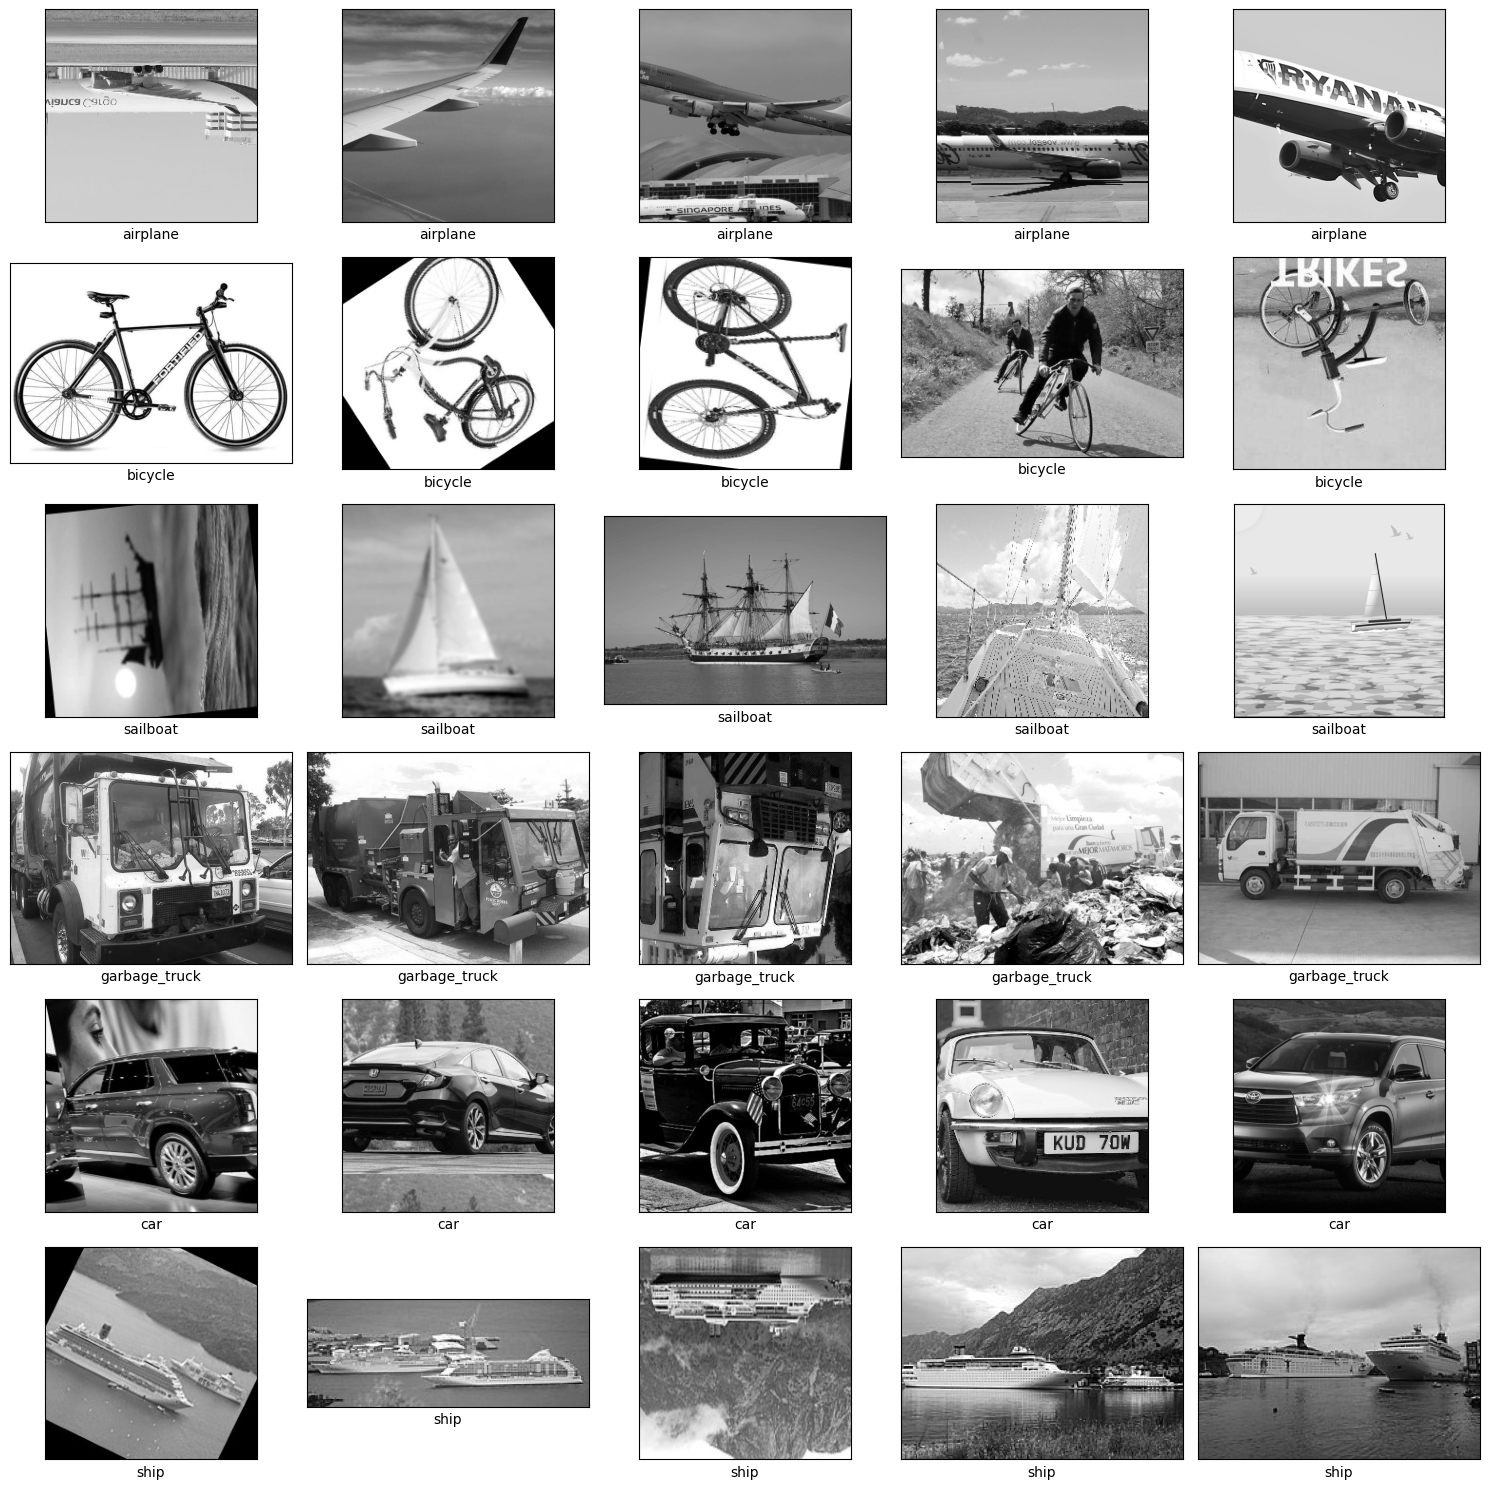

In [13]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
vehicle_image = {}

# Tentukan path sumber train
path = "vehicle/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    vehicle_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "vehicle/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(vehicle_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(vehicle_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

### Data Loading

In [14]:
import seaborn as sns

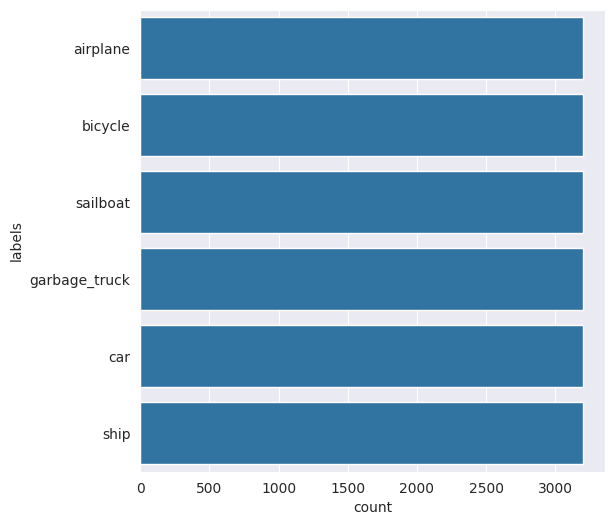

In [15]:
# Definisikan path sumber
flower_path = "vehicle/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(flower_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [16]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [17]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images_path="vehicle/dataset/airplane" # Path untuk gambar asli
augmented_path="vehicle/dataset/airplane" # Path untuk gambar yang sudah diaugmentasi
images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi, jumlahnya disesuaikan sesuai kebutuhan
# Variabel untuk melakukan iterasi sampai jumlah gambar yang ditentukan dalam images_to_generate
images_to_generate=2000
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

In [18]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images_path="vehicle/dataset/bicycle" # Path untuk gambar asli
augmented_path="vehicle/dataset/bicycle" # Path untuk gambar yang sudah diaugmentasi
images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi, jumlahnya disesuaikan sesuai kebutuhan
# Variabel untuk melakukan iterasi sampai jumlah gambar yang ditentukan dalam images_to_generate
images_to_generate=2000
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

In [19]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images_path="vehicle/dataset/car" # Path untuk gambar asli
augmented_path="vehicle/dataset/car" # Path untuk gambar yang sudah diaugmentasi
images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi, jumlahnya disesuaikan sesuai kebutuhan
# Variabel untuk melakukan iterasi sampai jumlah gambar yang ditentukan dalam images_to_generate
images_to_generate=2000
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

In [20]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images_path="vehicle/dataset/garbage_truck" # Path untuk gambar asli
augmented_path="vehicle/dataset/garbage_truck" # Path untuk gambar yang sudah diaugmentasi
images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi, jumlahnya disesuaikan sesuai kebutuhan
# Variabel untuk melakukan iterasi sampai jumlah gambar yang ditentukan dalam images_to_generate
images_to_generate=2000
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

In [21]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images_path="vehicle/dataset/sailboat" # Path untuk gambar asli
augmented_path="vehicle/dataset/sailboat" # Path untuk gambar yang sudah diaugmentasi
images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi, jumlahnya disesuaikan sesuai kebutuhan
# Variabel untuk melakukan iterasi sampai jumlah gambar yang ditentukan dalam images_to_generate
images_to_generate=2000
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

In [22]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images_path="vehicle/dataset/ship" # Path untuk gambar asli
augmented_path="vehicle/dataset/ship" # Path untuk gambar yang sudah diaugmentasi
images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi, jumlahnya disesuaikan sesuai kebutuhan
# Variabel untuk melakukan iterasi sampai jumlah gambar yang ditentukan dalam images_to_generate
images_to_generate=2000
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

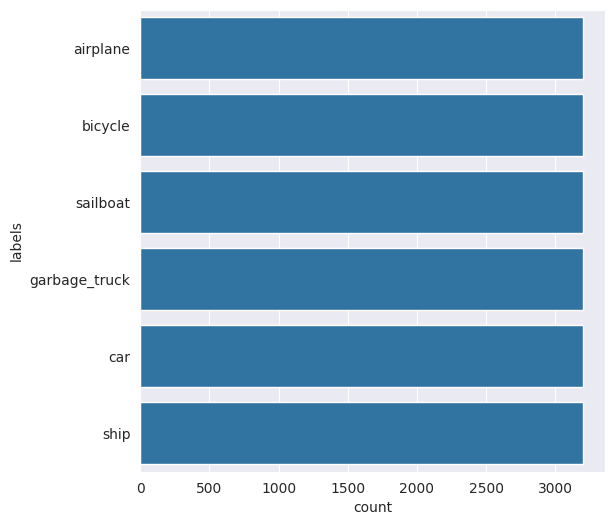

In [23]:
# Definisikan path sumber
vehicle_path = "vehicle/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(vehicle_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [24]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'vehicle/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
airplane,3200
bicycle,3200
car,3200
garbage_truck,3200
sailboat,3200
ship,3200


In [25]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [26]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [27]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "vehicle/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels       
test   airplane          615
       bicycle           635
       car               677
       garbage_truck     600
       sailboat          668
       ship              645
train  airplane         2585
       bicycle          2565
       car              2523
       garbage_truck    2600
       sailboat         2532
       ship             2555
dtype: int64 


                                                    path    labels    set
14386       vehicle/dataset/car/augmented_image_1024.jpg       car  train
11941           vehicle/dataset/bicycle/bicycle_0838.jpg   bicycle  train
6060       vehicle/dataset/ship/augmented_image_1210.jpg      ship  train
18967         vehicle/dataset/airplane/airplane_0267.jpg  airplane   test
14929  vehicle/dataset/sailboat/augmented_image_1250.jpg  sailboat  train


In [28]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [29]:
# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_airplane = os.path.join(TRAIN_DIR + '/airplane')
train_bicycle = os.path.join(TRAIN_DIR + '/bicycle')
train_car = os.path.join(TRAIN_DIR + '/car')
train_garbagetruck = os.path.join(TRAIN_DIR + '/garbage_truck')
train_sailboat = os.path.join(TRAIN_DIR + '/sailboat')
train_ship = os.path.join(TRAIN_DIR + '/ship')

test_airplane = os.path.join(TEST_DIR + '/airplane')
test_bicycle = os.path.join(TEST_DIR + '/bicycle')
test_car = os.path.join(TEST_DIR + '/car')
test_garbagetruck = os.path.join(TEST_DIR + '/garbage_truck')
test_sailboat = os.path.join(TEST_DIR + '/sailboat')
test_ship = os.path.join(TEST_DIR + '/ship')

print("Total number of airplane images in training set: ",len(os.listdir(train_airplane)))
print("Total number of bicycle images in training set: ",len(os.listdir(train_bicycle)))
print("Total number of car images in training set: ",len(os.listdir(train_car)))
print("Total number of garbage_truck images in training set: ",len(os.listdir(train_garbagetruck)))
print("Total number of sailboat images in training set: ",len(os.listdir(train_sailboat)))
print("Total number of ship images in training set: ",len(os.listdir(train_ship)))

print("Total number of airplane images in test set: ",len(os.listdir(test_airplane)))
print("Total number of bicycle images in test set: ",len(os.listdir(test_bicycle)))
print("Total number of car images in test set: ",len(os.listdir(test_car)))
print("Total number of garbage_truck images in test set: ",len(os.listdir(test_garbagetruck)))
print("Total number of sailboat images in test set: ",len(os.listdir(test_sailboat)))
print("Total number of ship images in test set: ",len(os.listdir(test_ship)))

Total number of airplane images in training set:  2585
Total number of bicycle images in training set:  2565
Total number of car images in training set:  2523
Total number of garbage_truck images in training set:  2600
Total number of sailboat images in training set:  2532
Total number of ship images in training set:  2555
Total number of airplane images in test set:  615
Total number of bicycle images in test set:  635
Total number of car images in test set:  677
Total number of garbage_truck images in test set:  600
Total number of sailboat images in test set:  668
Total number of ship images in test set:  645


## Modelling

In [30]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Generator untuk training
train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              shuffle=True)

# Generator untuk validation
validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="grayscale",
                                                   class_mode='categorical',
                                                   shuffle=False)

# Generator untuk testing
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 15360 images belonging to 6 classes.
Found 15360 images belonging to 6 classes.
Found 3840 images belonging to 6 classes.


In [31]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())

# 1st Dense Layer
model_1.add(Dense(128, activation='relu'))

# 1st Dropout Layer
model_1.add(Dropout(0.5))

# 2nd Dense Layer
model_1.add(Dense(64, activation='relu'))

# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer => For output prediction, 5 neurons for 5 classes, softmax for multi-class
model_1.add(Dense(6, activation='softmax'))

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='categorical_crossentropy',  # Multi-class loss function
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,327,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,403,206 (5.35 MB)

 Trainable params: 1,403,014 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [32]:
# Hitung jumlah gambar di setiap kategori untuk training set
count_airplane = len(os.listdir(train_airplane))
count_bicycle = len(os.listdir(train_bicycle))
count_car = len(os.listdir(train_car))
count_garbagetruck = len(os.listdir(train_garbagetruck))
count_sailboat = len(os.listdir(train_sailboat))
count_ship = len(os.listdir(train_ship))

# Total jumlah gambar di training set
total_samples = (
    count_airplane + count_bicycle + count_car +
    count_garbagetruck + count_sailboat + count_ship
)

# Hitung bobot untuk masing-masing kelas
weight_airplane = total_samples / (6.0 * count_airplane)
weight_bicycle = total_samples / (6.0 * count_bicycle)
weight_car = total_samples / (6.0 * count_car)
weight_garbagetruck = total_samples / (6.0 * count_garbagetruck)
weight_sailboat = total_samples / (6.0 * count_sailboat)
weight_ship = total_samples / (6.0 * count_ship)

# Dictionary class weights
class_weights = {
    0: weight_airplane,
    1: weight_bicycle,
    2: weight_car,
    3: weight_garbagetruck,
    4: weight_sailboat,
    5: weight_ship,
}

# Output jumlah gambar dan bobot kelas
print("Jumlah gambar per kategori di training set:")
print(f"Airplane: {count_airplane}")
print(f"Bicycle: {count_bicycle}")
print(f"Car: {count_car}")
print(f"Garbage Truck: {count_garbagetruck}")
print(f"Sailboat: {count_sailboat}")
print(f"Ship: {count_ship}")
print("\nTotal jumlah gambar:", total_samples)
print("\nClass weights:", class_weights)

Jumlah gambar per kategori di training set:
Airplane: 2585
Bicycle: 2565
Car: 2523
Garbage Truck: 2600
Sailboat: 2532
Ship: 2555

Total jumlah gambar: 15360

Class weights: {0: 0.9903288201160542, 1: 0.9980506822612085, 2: 1.0146650812524771, 3: 0.9846153846153847, 4: 1.0110584518167456, 5: 1.0019569471624266}


In [33]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):  # Change to logs=None
    logs = logs or {}  # Ensure logs is a dictionary
    if(logs.get('accuracy', 0) > 0.85 and logs.get('val_accuracy', 0) > 0.85):
      print("\nAkurasi dan Val Akurasi telah mencapai >85%!")
      self.model.stop_training = True
callbacks = myCallback()

In [34]:
# Fitting / training model
history_1 = model_1.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight = class_weights,
    callbacks=[callbacks]
    )

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


480/480 ━━━━━━━━━━━━━━━━━━━━ 90s 171ms/step - accuracy: 0.2995 - loss: 2.5035 - val_accuracy: 0.4684 - val_loss: 1.3720
Epoch 2/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 127s 153ms/step - accuracy: 0.5217 - loss: 1.3353 - val_accuracy: 0.3270 - val_loss: 4.2404
Epoch 3/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 74s 154ms/step - accuracy: 0.6442 - loss: 1.0404 - val_accuracy: 0.1933 - val_loss: 15.1977
Epoch 4/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 75s 155ms/step - accuracy: 0.7083 - loss: 0.8727 - val_accuracy: 0.6061 - val_loss: 1.2182
Epoch 5/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 73s 152ms/step - accuracy: 0.7487 - loss: 0.7532 - val_accuracy: 0.3182 - val_loss: 14.3528
Epoch 6/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 90s 168ms/step - accuracy: 0.7728 - loss: 0.7028 - val_accuracy: 0.7623 - val_loss: 0.8579
Epoch 7/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 74s 154ms/step - accuracy: 0.8075 - loss: 0.6041 - val_accuracy: 0.7693 - val_loss: 0.7721
Epoch 8/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 81s 167ms/step - accuracy: 0.8196 - loss: 0.5561 - 

## Evaluasi dan Visualisasi

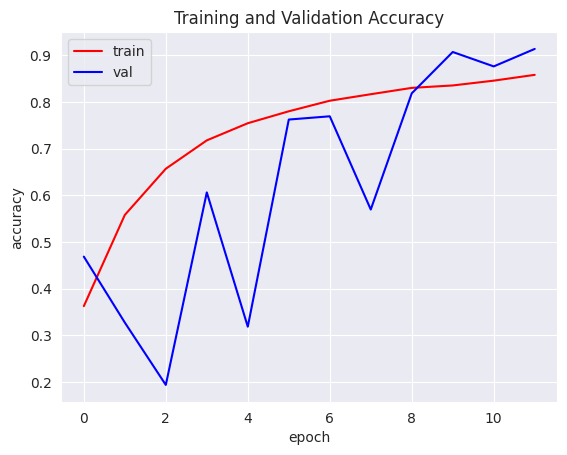

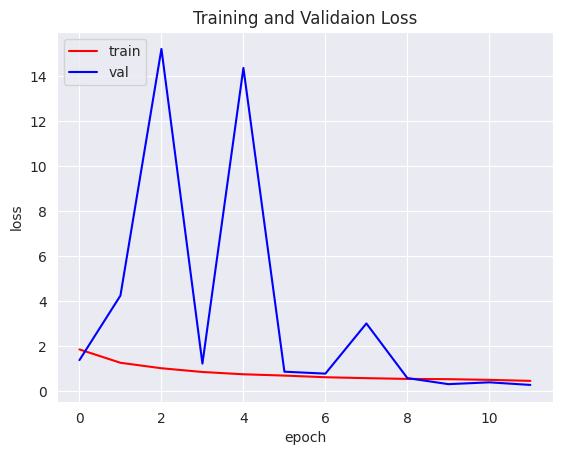

In [35]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

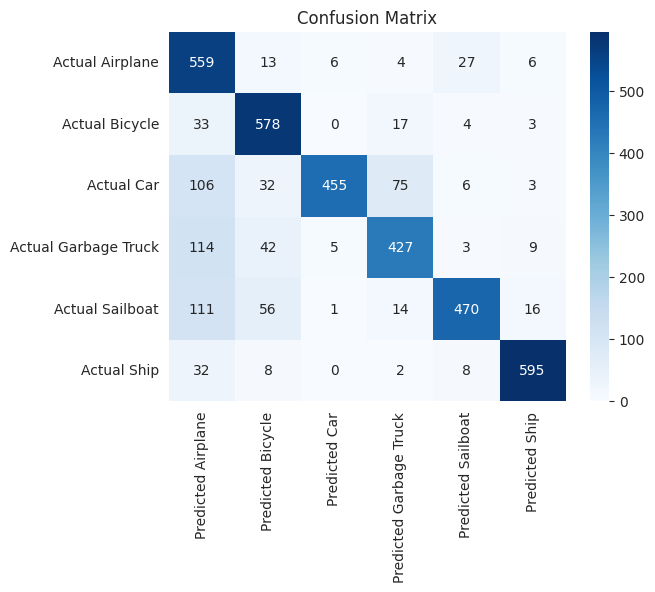


Classification Report:
               precision    recall  f1-score   support

     Airplane     0.5853    0.9089    0.7121       615
      Bicycle     0.7929    0.9102    0.8475       635
          Car     0.9743    0.6721    0.7955       677
Garbage Truck     0.7922    0.7117    0.7498       600
     Sailboat     0.9073    0.7036    0.7926       668
         Ship     0.9415    0.9225    0.9319       645

     accuracy                         0.8031      3840
    macro avg     0.8323    0.8048    0.8049      3840
 weighted avg     0.8364    0.8031    0.8060      3840



In [36]:
# Reset test generator
test_generator.reset()

# Prediksi dengan model
preds_1 = model_1.predict(test_generator, verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Label kelas
class_labels = ['Airplane', 'Bicycle', 'Car', 'Garbage Truck', 'Sailboat', 'Ship']

# Print Confusion Matrix
cm = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds_1.argmax(axis=1), labels=range(len(class_labels))),
    index=[f"Actual {label}" for label in class_labels],
    columns=[f"Predicted {label}" for label in class_labels]
)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(
    y_true=test_generator.classes,
    y_pred=preds_1.argmax(axis=1),
    target_names=class_labels,
    digits=4
))

## Konversi Model

In [37]:
model_1.save("model.h5")

In [38]:
# Install tensorflowjs
!pip install tensorflowjs

# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 113.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully un

2024-11-28 11:41:32.807897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732794092.828553   36643 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732794092.834943   36643 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)